# **Lab 1: k-Nearest Neighbours and Cross Validation**

CS 412, Spring 2021

***This is an individual lab, i.e., NOT for group work.***

This is your first lab. You will see how to use k-Nearest Neighbours for classification tasks. You will also learn how to do model selection by cross validation. In particular, we will help you to get started with these algorithms _step by step_.

***Deadline:***
This assignment is due **Feb 10** (Anywhere on Earth, [AoE](https://www.timeanddate.com/time/zones/aoe)). That is, you can resubmit as often as you like provided that anywhere on Earth is still on or before this date. 

***How to submit:***
See bottom of the page

***Python version:***
The code should work on Python 3.7 or later, though it might work on earlier versions (not tested). There should be no version problem if you work on Colab.  See a more detailed introduction to Python and Colab at this [link](https://colab.research.google.com/github/cs231n/cs231n.github.io/blob/master/python-colab.ipynb#scrollTo=nxvEkGXPM3Xh).  

**Please note before starting the lab:**

1. If you use Colab, copy this file to your own Google Drive so that you can edit it.

2. Since the experiments involve randomness, it is important to ensure that your results are replicable. To this end, your implementation should take one integer (or any numeric value) as a seed that is used to initialize the random number generators.
See, e.g. [random.seed](https://docs.python.org/3/library/random.html).
This has been done for you in the first code block below.

3. <font color='red'> There are unit test cases provided after most functions you need to implement. Make good use of them.</font>  For numerical results (i.e., not discrete values), it is fine if your result is within 1% relative difference from the reference result.


## Problem 1: Implementation of the k-Nearest Neighbours (kNN) classifier and Cross-Validation {-}

In Problem 1, you will implement kNN and cross validation from scratch, which is a good exercise to make sure that you fully understand those algorithms.
Do not use any library such as scikit-learn that already has kNN or cross validation implemented.
But you can use general libraries for array and matrix operations such as numpy.

##1.1 Implementation of the k-Nearest Neighbours classifier



**Step 1. (10 points)** The kNN classifier mainly consists of two stages:

1.   During training, the classifier takes the training data and simply stores it.
2.   During testing, kNN classifies every test example $x$ by 

> i) finding the $k$ training examples that are most similar to $x$;

> ii) outputing the most common label among these $k$ examples.

To measure the similarity between samples, we commonly compute the Euclidean distance. The Euclidean distance (a.k.a. $L_2$ distance) between two examples $p$ and $q$ in an $n$-dimensional space is defined as the square root of:

\begin{equation}
(p_1-q_1)^2 + (p_2-q_2)^2 + ... + (p_n-q_n)^2. \tag{1}
\end{equation}

This term is equal to 
\begin{equation}
\sum_i p_i^2 + \sum_i q_i^2 - 2 \sum_i p_i q_i. \tag{2}
\end{equation}


With Euclidean distance, the smaller the value, the more similar the two examples are. Actually, there are many different ways to measure the similarity, such as cosine distance, Manhattan, Chebyshev, and Hamming distance. In practice, you can choose the one that suits your problem. For this lab, we will implement Equation (2) with a function `my_euclidean_dist` that  computes the Euclidean distances.

**DO NOT use np.linalg.norm() or function from scipy.**

**Unit test:** to unit test `my_euclidean_dist`, you can construct two matrices by yourself, e.g., `X_train` being 3-by-2 and `X_test` being 2-by-2. Then you can compute the squared Euclidean distances by hand, and compare it with the result of your code.  See the last four lines of the following code block, which lie outside the definition of `my_euclidean_dist`.  You can uncomment them for testing, but comment them back when you finish the entire lab.

`euclidean_dist` will be called eventually by the `knn_predict` function in Step 3 below.

In [2]:
# set up code for this experiment
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(1)

In [3]:
def my_euclidean_dist(X_test, X_train):
  """
  Compute the *squared* distance between each test example and each training example

  Input:
  - X_test: A numpy array of shape (num_test, dim_feat) containing test data
  - X_train: A numpy array of shape (num_train, dim_feat) containing training data

  Output:
  - dists: A numpy array of shape (num_test, num_train) where 
           dist[i, j] is the squared Euclidean distance between 
           the i-th test example and the j-th training example
  """
  num_test = X_test.shape[0]
  num_train = X_train.shape[0]
  dists = np.zeros((num_test, num_train))
  # TODO:
  # Compute the squared L2 distance between all test and training examples.
  #
  # One most straightforward way is to use nested for loop
  # to iterate over all test and training samples.
  # Here is the pseudo-code:
  # for i = 0 ... num_test - 1
  #    a[i] = square of the norm of the i-th test example
  # for j = 0 ... num_train - 1
  #    b[j] = square of the norm of the j-th training example
  # for i = 0 ... num_test - 1
  #    for j = 0 ... num_train - 1
  #        dists[i, j] = a[i] + b[j] - 2 * np.dot(i-th test example, j-th training example)
  # return dists
  
  # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

  a = []
  for x in range(num_test):
    a.append(np.sum(np.square(X_test[x])))

  b = []
  for x in range(num_train):
    b.append(np.sum(np.square(X_train[x])))

  for x in range(num_test):
    for y in range(num_train):
      dists[x,y] = a[x] + b[y] - 2 * np.dot(X_test[x], X_train[y])
  

  # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)***** 

  return dists

# Unit test code here (you can uncomment the four lines below to test)
# Compute by hand to check if the result is correct.
# The right matrix of squared distance should be
# [[ 8 10  1]
#  [ 2  8  9]]
# X_train = np.array([[1, 2], [0, 3], [-1, 1]])
# X_test = np.array([[-1, 0], [2, 1]])
# my_dists = my_euclidean_dist(X_test, X_train)
# print(my_dists)

However, you can entirely avoid using loops by reformulating Equation (2) with linear algebra.  The trick is to reformulate the L2 distance as two broadcast sums and matrix multiplication.  

**Task:** Try the following implementation and feel the speedup!  Understand the following implementation.  You do not need to write down your understanding or submit anything for it, but it will be helpful to understand it.

**Note:**  Since Euclidean distance computation underlies all the subsequent experiments, its efficiency is highly important. Therefore, in the sequel, we will NOT use `my_euclidean_dist` that you just implemented.  Instead, we will use `euclidean_dist`.  However, your implementation of `my_euclidean_dist` will still be graded based on unit test; it will need to be copied to `Lab_1.py` (see submission instruction at the bottom of the page).

In [22]:
def euclidean_dist(X_test, X_train):
  dists = np.add(np.sum(X_test ** 2, axis=1, keepdims=True), np.sum(X_train ** 2, axis=1, keepdims=True).T) - 2* X_test @ X_train.T
  return dists

#Unit test code here (you can uncomment the four lines below to test)
# X_train = np.array([[1, 2], [0, 3], [-1, 1]])
# X_test = np.array([[-1, 0], [2, 1]])
# dists = euclidean_dist(X_test, X_train)
# print(dists)

**Step 2. (10 points)**  Once distances are calculated, we can find the top $k$ nearest neighbors for each test example by retrieving from the dists matrix. 
In particular, for each test example $x$, we can sort all the training examples by their distance to $x$ then find the $k$ most nearest neighbors.  

**HINT**: Recall from the lecture that `argsort` is useful for this purpose.

**Note**: to run the unit test, you need to uncomment the unit test in the previous code block.

In [23]:
def find_k_neighbors(dists, Y_train, k):
  """
  find the labels of the top k nearest neighbors

  Inputs:
  - dists: distance matrix of shape (num_test, num_train)
  - Y_train: A numpy array of shape (num_train) containing ground true labels for training data
  - k: An integer, k nearest neighbors

  Output:
  - neighbors: A numpy array of shape (num_test, k), where each row containts the 
               labels of the k nearest neighbors for each test example
  """
  # TODO:
  # find the top k nearest neighbors for each test sample.
  # retrieve the corresponding labels of those neighbors.
  # Here is the pseudo-code:
  # for i = 0 ... num_test-1
  #     idx = numpy.argsort(i-th row of dists)
  #     neighbors[i] = Y_train(idx[0]), ..., Y_train(idx[k-1])
  # return neighbors
  # Advanced: You can accelerate the code by, e.g., argsort on the `dists` matrix directly

  # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  neighbors = []
  for i in range(dists.shape[0]):
    idx = np.argsort(dists[i])
    x = []
    for j in range(k):
      x.append(Y_train[idx[j]])
    neighbors.append(x)


  # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  return neighbors

# Unit test code here (you can uncomment the lines below to test)
# Compute by hand to check if the result is correct.
# k = 3   # you can vary it as 1 or 3
# Y_train = np.array([0, 1, 1])
# neighbors = find_k_neighbors(dists, Y_train, k)
# print(neighbors)

**Step 3. (10 points)** Finally, we can put together `euclidean_dist` and `find_k_neighbors`, so that labels can be predicted for test examples.  In kNN, we take the labels of the $k$ nearest neighbors and find the most common one and assign it to the test sample.

**Hint:** You may find [`np.unique`](https://numpy.org/doc/stable/reference/generated/numpy.unique.html#numpy-unique) and `argmax` useful.

In [24]:
def knn_predict(X_test, X_train, Y_train, k):
  """
  predict labels for test data.

  Inputs:
  - X_test: A numpy array of shape (num_test, dim_feat) containing test data.
  - X_train: A numpy array of shape (num_train, dim_feat) containing training data.
  - Y_train: A numpy array of shape (num_train) containing ground true labels for training data
  - k: An integer, k nearest neighbors

  Output:
  - Y_pred: A numpy array of shape (num_test). Predicted labels for the test data.
  """
  # TODO:
  # find the labels of k nearest neighbors for each test example,
  # and then find the majority label out of the k labels
  #
  # Here is the pseudo-code:
  # dists = euclidean_dist(X_test, X_train)
  # neighbors = find_k_neighbors(dists, Y_train, k)
  # Y_pred = np.zeros(num_test, dtype=int)  # force dtype=int in case the dataset
  #                                         # stores labels as float-point numbers
  # for i = 0 ... num_test-1
  #     Y_pred[i] = # the most common/frequent label in neighbors[i], you can
  #                 # implement it by using np.unique
  # return Y_pred

  # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

  dists = euclidean_dist(X_test, X_train)
  neighbors = find_k_neighbors(dists, Y_train, k)
  
  Y_pred = np.zeros(X_test.shape[0], dtype=int)

  for i in range(X_test.shape[0]):
    elements, counts = np.unique(neighbors[i], return_counts=True)
    Y_pred[i] = elements[np.argmax(counts)]

  # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  return Y_pred

# Unit test code here (you can uncomment the lines below to test)
# Compute by hand to check if the result is correct.
# Y_pred = knn_predict(X_test, X_train, Y_train, k)
# print(Y_pred)

**Step 4. (5 points)** Once we obtain the predicted labels, we need to implement a function to compare them against the true label and compute the error rate in percentage (i.e., a number between 0 and 100). In the following code block, implement the `compute_error_rate` function by following the specified inputs and output.

In [25]:
def compute_error_rate(ypred, ytrue):
  """
  Compute error rate given the predicted results and true lable.
  Inputs:
  - ypred: array of prediction results.
  - ytrue: array of true labels.
    ypred and ytrue should be of same length.
  Output:
  - error rate: float number indicating the error in percentage
                (i.e., a number between 0 and 100).
  """
  # Here is the pseudo-code:
  # err = 0
  # for i = 0 ... num_test - 1
  #     err = err + (ypred[i] != ytrue[i])  # generalizes to multiple classes
  # error_rate = err / num_test * 100
  # return error_rate
  #
  # Advanced (optional): 
  #   implement it in one line by using vector operation and the `mean` function

  # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

  err = 0
  for i in range(len(ypred)):
    err = err + (ypred[i] != ytrue[i])
  error_rate = (err / len(ypred)) * 100

  # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  return error_rate

## 1.2 Splitting training data for cross validation {-}

Cross validation is a technique in which we train our model using a subset of the available dataset and then evaluate using the complementary subset of the data. In this assignment, we use the $n$-fold cross validation method to perform cross validation. In $n$-fold cross validation, we evenly partition the dataset into $n$ mutually disjoint subsets (a.k.a. _folds_). We train an ML model on all but one subset (i.e., train on the union of $n-1$ folds), and then evaluate the model on the subset that was left out.  The former is called _training subset_, while the latter is called _validation subset_. This process is repeated $n$ times, with a different subset reserved for evaluation (and excluded from training) each time. If the size of the dataset is not exactly divisible by $n$, the remainder can be arbitrarily distributed into the folds.

**Step 1. (10 points)** In the following code block, you will need to implement a function that partitions the dataset in to training sets and validation sets. The output should be lists of indices which indicate the training examples and validation examples.  Function inputs and outputs are detailed in the code block. 

**Hint:** You may find random permutation useful here: [np.random.permutation](https://numpy.org/doc/stable/reference/random/generated/numpy.random.permutation.html)

In [26]:
def split_nfold(num_examples, n):
  """
  Split the dataset in to training sets and validation sets.
  Inputs:
  - num_examples: Integer, the total number of examples in the dataset
  - n: number of folds
  Outputs:
  - train_sets: List of lists, where train_sets[i] (i = 0 ... n-1) contains 
                the indices of examples for training
  - validation_sets: List of list, where validation_sets[i] (i = 0 ... n-1) 
                contains the indices of examples for validation

  Example:
  When num_examples = 10 and n = 5, 
    the output train_sets should be a list of length 5, 
    and each element in this list is itself a list of length 8, 
    containing 8 indices in 0...9
  For example, 
    we can initialize by randomly permuting [0, 1, ..., 9] into, say,
      [9, 5, 3, 0, 8, 4, 2, 1, 6, 7]
    Then we can have
    train_sets[0] = [3, 0, 8, 4, 2, 1, 6, 7],  validation_sets[0] = [9, 5]
    train_sets[1] = [9, 5, 8, 4, 2, 1, 6, 7],  validation_sets[1] = [3, 0]
    train_sets[2] = [9, 5, 3, 0, 2, 1, 6, 7],  validation_sets[2] = [8, 4]
    train_sets[3] = [9, 5, 3, 0, 8, 4, 6, 7],  validation_sets[3] = [2, 1]
    train_sets[4] = [9, 5, 3, 0, 8, 4, 2, 1],  validation_sets[4] = [6, 7]
  Within train_sets[i] and validation_sets[i], the indices do not need to be sorted.
  """
  # Here is the pseudo code:
  # idx = np.random.permutation(num_examples).tolist() # generate random index list
  # fold_size = num_examples//n   # compute how many examples in one fold.
  #                               # note '//' as we want an integral result
  # train_sets = []
  # validation_sets = []
  # for i = 0 ... n-1
  #	  start = # compute the start index of the i-th fold
  #	  end = # compute the end index of the i-th fold
  #   if i == n-1
  #     end = num_examples  # handle the remainder by allocating them to the last fold
  #   For example, when num_examples = 11 and n = 5, 
  #     fold_size = 11//5 = 2
  #     i = 0: start = 0, end = 2
  #     i = 1: start = 2, end = 4
  #     i = 2: start = 4, end = 6
  #     i = 3: start = 6, end = 8
  #     i = 4: start = 8, end = 11  (take up the remainder of 11//5)
  #
  #   # Now extract training example indices from the idx list using start and end
  #   train_set = idx[`0 to num_example-1` except `start to end-1`]  
  #   train_sets.append(train_set)
  #
  #   # Extract validation example indices from the idx list using start and end
  #   val_set = idx[start to end-1] 
  #   validation_sets.append(val_set)
  
  # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

  idx = np.random.permutation(num_examples).tolist()
  fold_size = num_examples//n
  train_sets = []
  validation_sets = []
  for i in range(n):
    start = i * fold_size
    end = start + fold_size
    if i == n - 1:
      end = num_examples

    train_set = idx[:start]+idx[end:]
    train_sets.append(train_set)

    val_set = idx[start:end]
    validation_sets.append(val_set)

  # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  return train_sets, validation_sets

# Unit test code here (you can uncomment the lines below to test)
# train_sets, val_sets = split_nfold(11, 5)
# print(train_sets[4])
# print(val_sets[4])

**Step 2. (10 points)** Next, you will need to implement the `cross_validation` function, which will output the cross validation error rate. You may want to call previously defined functions such as `split_nfold` and `compute_error_rate`. In this function, you need to loop over each of the $n$ training/validation partitions in the output of `split_nfold`.
Then perform training on train_sets[i] and compute the test error on validation_sets[i].  The final cross validation error rate is the average error rate over all partitions. 

To improve generality, `cross_validation` takes as its first input argument a generic _classifier_ function.  In this lab, we will use kNN, and _classifier_ should be instantiated by the `knn_predict` function that is implemented above. In general, the _classifier_ function should conform with a prescribed protocol of prototype, i.e., what the input and output arguments are.  For example its inputs are `(X_test, X_train, Y_train, k)` and its output is `Y_pred`.

**Hint:** You may need to know how to use [*args](https://book.pythontips.com/en/latest/args_and_kwargs.html)

In [27]:
def cross_validation(classifier, X, Y, n, *args):
  """
  Perform cross validation for the given classifier, 
      and return the cross validation error rate.
  Inputs:
  - classifier: function of classification method
  - X: A 2-D numpy array of shape (num_train, dim_feat), containing the whole dataset
  - Y: A 1-D numpy array of length num_train, containing the ground-true labels
  - n: number of folds
  - *args: parameters needed by the classifier.
        In this assignment, there is only one parameter (k) for the kNN clasifier.
        For other classifiers, there may be multiple paramters. 
        To keep this function general, 
        let's use *args here for an unspecified number of paramters.
  Output:
  - error_rate: a floating-point number indicating the cross validation error rate
  """
  # Here is the pseudo code:
  # errors = []
  # size = X.shape[0] # get the number of examples
  # train_sets, val_sets = split_nfold(size, n)  # call the split_nfold function
  #
  # for i in range(n):
  #   train_index = train_sets[i]
  #   val_index = val_sets[i]
  #   # get the training and validation sets of input features from X
  # 	X_train, X_val = X[...], X[...] 
  #
  #   # get the training and validation labels from Y
  # 	y_train, y_val = Y[...], Y[...] 
  #
  #   # call the classifier to get prediction results for the current validation set
  # 	ypred = # call classifier with X_val, X_train, y_train, and *args
  #                                   
  # 	error = # call compute_error_rate to compute the error rate by comparing ypred against y_val
  # 	append error to the list `errors`
  # error_rate = mean of errors
  np.random.seed(1)
  # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  errors = []
  size = X.shape[0]
  train_sets, val_sets = split_nfold(size, n)

  for i in range(n):
    train_index = train_sets[i]
    val_index = val_sets[i]

    X_train, X_val = X[train_index], X[val_index]

    y_train, y_val = Y[train_index], Y[val_index]

    y_pred = classifier(X_val, X_train, y_train, args[0])

    error = compute_error_rate(y_pred, y_val)
    errors.append(error)
    error_rate = sum(errors)/len(errors)

  # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  
  return error_rate 

# Unit test code here (you can uncomment the lines below to test)
# X_dataset = np.array([[1, 2], [0, 3], [-1, 1], [-1, 0], [2, 1]])
# Y_dataset = np.array([1, 1, 1, 0, 0])
# n = 5
# k = 3
# cross_validation(knn_predict, X_dataset, Y_dataset, n, k)

Side note: instead of `for i in range(n):`, you can also use

`for (train_index, val_index) in zip(train_sets, val_sets):`

Try it if you like as it can be more generic. No need to submit anything for it.

## Problem 2: Optical character recognition (OCR) {-}

We will now apply the above developed function to a real world problem of optical character recognition (OCR).

**Load the MNIST dataset.** In the following code block, we have downloaded the MNIST dataset and split the data into trainning and test sets. This part has already been done, and you can directly run it with no need of modifying the code.  But do make sure that you understand the code as it will be useful for future labs.

**Note:** after running the code, the training data (Xtrain, ytrain) has 10,000 examples, and the test data (Xtest, ytest) also has 10,000 examples.

In [28]:
import os
import gzip

DATA_URL = 'http://yann.lecun.com/exdb/mnist/'

# Download and import the MNIST dataset from Yann LeCun's website.
# Each image is an array of 784 (28x28) float values  from 0 (white) to 1 (black).
def load_data():
    x_tr = load_images('train-images-idx3-ubyte.gz')
    y_tr = load_labels('train-labels-idx1-ubyte.gz')
    x_te = load_images('t10k-images-idx3-ubyte.gz')
    y_te = load_labels('t10k-labels-idx1-ubyte.gz')

    return x_tr, y_tr, x_te, y_te

def load_images(filename):
    maybe_download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    return data.reshape(-1, 28 * 28) / np.float32(256)

def load_labels(filename):
    maybe_download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

# Download the file, unless it's already here.
def maybe_download(filename):
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        print("Downloading %s" % filename)
        urlretrieve(DATA_URL + filename, filename)

Xtrain, ytrain, Xtest, ytest = load_data()

train_size = 10000
test_size  = 10000

Xtrain = Xtrain[0:train_size]
ytrain = ytrain[0:train_size]

Xtest = Xtest[0:test_size]
ytest = ytest[0:test_size]

##2.1 Effect of different numbers of training examples

**(10 points)** In the following code block, we will compute the classification error of the 1-NN ($k=1$) for the MNIST dataset by calling the `knn_predict` function. We will study does the error change with different number of training examples.

**Tasks**: train on the **first** $ntr$ number of training examples in (Xtrain, ytrain) that is produced by the above data-loading code, where $ntr$ is varied in $\{100, 1000, 2500, 5000, 7500, 10000\}$.
1. Print the test error rate for each of these values of $ntr$.  Note that the above data-loading code produces 10,000 test examples stored in (Xtest, ytest). Just use all of them for testing, i.e., fixing the test set size to 10000.
2. Plot a figure where the $x$-axis is the above values of $ntr$, and the $y$-axis is the test error rate.

Directly calling `knn_predict` with the training and test set may cost too much memory.  So we will classify the test examples in batches, i.e., divide the test set into `nbtaches` number of subsets/batches, and predict for the first batch, then second batch, etc. For example, with 30 test examples and 5 batches, we first use `knn_predict` to classify test examples 0...5, then 6...11, ..., and finally 26...29.

**Hint:** you may refer [here](https://matplotlib.org/tutorials/introductory/pyplot.html) for how to plot in python.

#tr = 100, error rate = 32.06
#tr = 1000, error rate = 13.100000000000001
#tr = 2500, error rate = 8.64
#tr = 5000, error rate = 6.569999999999999
#tr = 7500, error rate = 5.91
#tr = 10000, error rate = 5.37


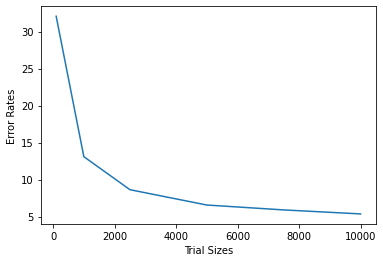

In [30]:
#  nbatches must be an even divisor of test_size. Increase if you run out of memory 
if test_size > 1000:
  nbatches = 50
else:
  nbatches = 5

# Let us first set up the index of each batch. 
# After running the next line, 'batches' will be a 2D array sized nbatches-by-m,
# where m = test_size / nbatches.
# batches[i] stores the indices (out of 0...test_size-1) for the i-th batch
# You can run 'print(batches[3])' etc to witness the value of 'batches'.
batches = np.array_split(np.arange(test_size), nbatches)
ypred = np.zeros_like(ytest)
trial_sizes = [100, 1000, 2500, 5000, 7500, 10000]
trials = len(trial_sizes)
error_rates = [0]*trials
k = 1

# Here is the pseudo code:
# 
# for t = 0 ... trials-1  # loop over different number of training examples
# 	trial_size = trial_sizes[t]
# 	trial_X = Xtrain[...] # extract trial_size number of training examples from the whole training set
# 	trial_Y = Ytrain[...] # extract the corresponding labels
# 	for i = 0…nbatches—1
# 		ypred[...] = # call knn_predict to classify the i-th batch of test examples.
#                  # You should use 'batches' to get the indices for batch i.
#                  # Then store the predicted labels also in the corresponding
#                  # elements of ypred, so that after the loop over i completes,
#                  # ypred will hold exactly the predicted labels of all test examples.
# 	error_rate[t] = # call compute_error_rate to compute the error rate by 
#                     comparing ypred against ytest
#   print a line like '#tr = 100, error rate = 50.3%'
# plot the figure:
# f = plt.figure()
# plt.plot(...)
# plt.xlabel(...)
# plt.ylabel(...)
# plt.show()


# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for t in range(trials):
  trial_size = trial_sizes[t]
  trial_X = Xtrain[:trial_size]
  trial_Y = ytrain[:trial_size]
  for i in range(nbatches):
    ypred[batches[i]] = knn_predict(Xtest[batches[i]],trial_X, trial_Y,k)
  
  error_rates[t] = compute_error_rate(ypred,ytest)
  print("#tr = "+ str(trial_size) + ", error rate = " + str(error_rates[t]))

f = plt.figure()
plt.plot(trial_sizes,error_rates)
plt.xlabel("Trial Sizes")
plt.ylabel("Error Rates")
plt.show()

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****



##2.2 Effect of different number of cross validation folds

**(10 points)** In the following code block, we will perform cross validation on 1-NN classification. Call the `knn_predict` and `cross_validation` functions you have implemented, and compute the cross validation error rate for the first **1000** training examples with different number of folds $n \in \{3, 10, 50, 100, 1000\}$. Then **print** the error rate for each different $n$ and **plot** a figure where the $x$-axis is $n = \{3, 10, 50, 100, 1000\}$, and the $y$-axis is the $n$-fold cross validation error rate. 

**Note about terminology:** In Problem 1, we used the term _dataset_, and the $n$-fold partitioning was on the _dataset_.  Now in the current setting, these **1000** training examples correspond to the _dataset_. In other words, this Section 2.2 will **not** use the test examples loaded from Problem 2, nor the remaining $10000 - 1000 = 9000$ training examples.

3-folds error rate: 12.70%

10-folds error rate: 12.00%

50-folds error rate: 12.10%

100-folds error rate: 11.90%

1000-folds error rate: 11.80%



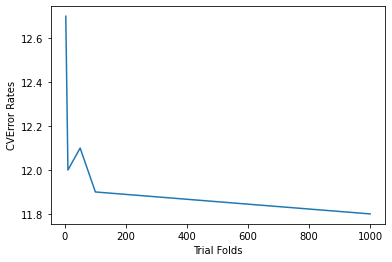

In [31]:

size = 1000
k = 1

# Here is the pseudo code:
#
# get the feature/label of the first 'size' (i.e., 1000) number of training examples
# cvXtrain = Xtrain[...]  
# cvytrain = ytrain[...]  

# trial_folds   = [3, 10, 50, 100, 1000]
# trials = number of trials on #folds, i.e., get the length of trial_folds (=5)
# cverror_rates = [0]*trials

# for t = 0 ... trials-1
# 	error_rate = # call the 'cross_validation' function to get the error rate 
#                #  for the current trial (of fold number)
# 	cverror_rates[t] = error_rate
#
#   # print the error rate for the current trial.
# 	print('{:d}-folds error rate: {:.2f}%\n'.format(trial_folds[t], error_rate)) 
#
# plot the figure:
# f = plt.figure()
# plt.plot(...)
# plt.xlabel(...)
# plt.ylabel(...)
# plt.show()

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
cvXtrain = Xtrain[:1000]
cvytrain = ytrain[:1000]

trial_folds   = [3, 10, 50, 100, 1000]
trials = len(trial_folds)
cverror_rates = [0]*trials

for t in range(trials):
  error_rate = cross_validation(knn_predict, cvXtrain, cvytrain, trial_folds[t], 1)
  cverror_rates[t] = error_rate

  print('{:d}-folds error rate: {:.2f}%\n'.format(trial_folds[t], error_rate))

f = plt.figure()
plt.plot(trial_folds,cverror_rates)
plt.xlabel("Trial Folds")
plt.ylabel("CVError Rates")
plt.show()
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


## Problem 3: Iris plant recognition {-}

The iris dataset includes 3 iris species of 50 examples each, where each example recorded petal and sepal length. For convenience, we will use the built-in functions in `scikit-learn` library to load dataset and create data partitions. For this experiment, we will use $80\%$ (120) examples for training and $20\%$ (30) for testing. 

Actually, we have done this data preparation work for you. You can directly use the training set (*X_train*, *Y_train*) and test set (*X_test*, *Y_test*) for the experiments, where *X* is features and *Y* is labels.


In [32]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# loading iris dataset
iris = load_iris()
# split dataset into training set and test set
X_train, X_test, Y_train, Y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=1)

### 3.1 Find the best $k$. {-}
In Problem 2, we conducted the experiments by arbitrarily setting $k$ to 1.
In fact, the value of $k$ has a considerable impact on the performance of kNN. We will now determine the best value of this hyperparameter with $10$-fold cross-validation.
To specify, we will vary $k$ in the range (1, 100) in increments of 1.
Then we will find the best $k$ in terms of the lowest validation error rate.
For this question, you need to:
* **(5 points)** Store the validation error for each $k$ in an array and report the value of the best $k$. 
* **(5 points)** Plot a curve that shows the validation error rates as $k$ increases. 

**Note about terminology:** In Problem 1, we used the term _dataset_, and the $n$-fold partitioning was on the _dataset_.  Now in the current setting, (X_strain, Y_train) loaded above correspond to the _dataset_. In other words, this Section 3.1 will **not** use the test examples loaded above.

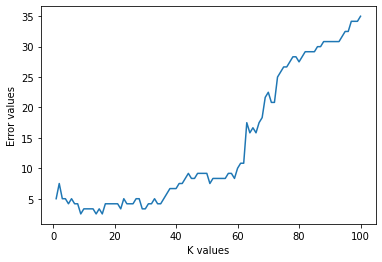

In [33]:
# Here is the pseudo code:
# list_ks = 1,2,...,100
# err_ks = 1D array of length 100
# for k in list_ks:
#   err_ks[k-1] = cross_validation under k 
# best_k = argmin(err_ks)+1
# plot err_ks versus list_ks

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
list_ks = range(1,101)
err_ks = np.zeros(100)

for k in list_ks:
  err_ks[k-1] = cross_validation(knn_predict, X_train, Y_train, 10, k)

best_k = np.argmin(err_ks)+1

f = plt.figure()
plt.plot(list_ks,err_ks)
plt.xlabel("K values")
plt.ylabel("Error values")
plt.show()

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


### 3.2 Evaluation on test set {-}
Since we have found the best hyperparameters for KNN classifier, it's time to evaluate this method on test data.

**Task (5 points):** Report the classification error of kNN on test data, where $k$ is the optimal one from Section 3.1 (break tie arbitrarily).

In [34]:
# Here is the pseudo code:
# y_pred = knn_predict on X_test using X_train, Y_train, and best_k
# use compute_error_rate to compute the error of y_pred compared with Y_test
# Print the error rate with a line like 'The test error is x.y%'


# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
y_pred = knn_predict(X_test,X_train, Y_train, best_k)
err_test = compute_error_rate(y_pred, Y_test)
print("The test error is {:.1f}%".format(err_test))
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


The test error is 3.3%


### 3.3 F-score measurement {-}
So far we have mainly used classification accuracy to evaluate the performance of our model. As a performance measure, accuracy is inappropriate for imbalanced classification problems.
An alternative is the F-score metrics.

**Tasks**
* **(5 points)** Implement the computation of the confusion matrix on test set using `y_test` and the prediction `y_pred` from Section 3.2.  You can compare your result with the one computed by [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) to ensure your implementation is correct.
* **(2 points)** Report the precision, recall, and F1-score for each class by using the built-in functions from [sklearn.metrics.classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html).
* **(3 points)** Write your own code to compute the F1-score for the three classes, and make sure they match the f1-score column of the sklearn result.

**Hint:**  All definitions of confusion matrix, precision, recall, and F1-score can be found in the slides for Chapter19: DESİGN AND ANALYSİS OF MACHİNE LEARNİNG EXPERİMENTS.

In [35]:
nclass = len(np.unique(Y_test))  # should be 3. Just be more adaptive to data.
cm = np.zeros((nclass, nclass), dtype=int)  # confusion matrix is integer valued

# Here is the pseudo code for Task 1: 
# for t = 0...nte-1  # nte is the number of test examples
#    cm[c1, c2] += 1  # c1 and c2 corresponds to the class of the t-th test example
#                     # according to Y_test and y_pred, respectively
#
# Here is the pseudo code for Task 3:
# Well, please consult the textbook, as I really hope you can do it yourself,
# especially when the right answer is provided by sklearn for comparison


# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
from sklearn.metrics import classification_report

for t in range(len(Y_test)):
  cm[Y_test[t],y_pred[t]] += 1

print(classification_report(Y_test, y_pred, target_names= ['class 0', 'class 1', 'class 2'] ))

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00        11
     class 1       1.00      0.92      0.96        13
     class 2       0.86      1.00      0.92         6

    accuracy                           0.97        30
   macro avg       0.95      0.97      0.96        30
weighted avg       0.97      0.97      0.97        30



# Submission Instruction {-}

You're almost done! Take the following steps to finally submit your work.

1. After executing all commands and completing this notebook, save your `Lab_1.ipynb` as a PDF file, named as `X_Y_UIN.pdf`, where `X` is your first name, `Y` is your last name, and `UIN` is your UIN. Make sure that your PDF file includes all parts of your solution, including the plots. 

> * Print out all unit test case results before printing the notebook into a PDF.
* If you use Colab, open this notebook in Chrome.  Then File -> Print -> set Destination to "Save as PDF".  If the web page freezes when printing, close Chrome and reopen the page. If Chrome doesn't work, try Firefox.
* If you are working on your own computer, we recommend using the browser (not jupyter) for saving the PDF. For Chrome on a Mac, this is under *File->Print...->Open PDF in Preview*. When the PDF opens in Preview, you can use *Save...* to save it.
* Sometimes, a figure that appears near the end of a page can get cut.  In this case, try to add some new lines in the preceding code block so that the figure is pushed to the beginning of the next page.

2. Upload `X_Y_UIN.pdf` to Gradescope under `Lab_1_Written`.

3. A template of `Lab_1.py` has been provided.  For all functions in `Lab_1.py`, copy the corresponding code snippets you have written into it.  Do not copy any code of plotting figures. **Do NOT** change the function names.

4. Zip `Lab_1.py` and `Lab_1.ipynb` (**2 files**) into a zip file named `X_Y_UIN.zip`. Suppose the two files are in the folder `Lab_1`.  Then zip up the two files inside the `Lab_1` folder.  Do NOT zip up the folder `Lab_1`. Submit this zip file to Gradescope under `Lab_1_Code`. 

5. The autograder on Gradscope will be open all the time. We designed some simple test cases to help you check wehther your functions are executable. You will see the results of running autograder once you submit your code. Please follow the error messages to debug. Since those simple test cases are designed for debugging, it does not guaranttee your solution will work well on the real dataset. It is your responsibility to make your code logically correct. Since all functions are tested in batch, the autograder might take a few minutes to run after submission.

You can submit to Gradescope as often as you like. We will only consider your last submission before the deadline.